In [1]:
pip install snowflake-snowpark-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.7/419.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 10.0 MB/s eta 0:00:00


In [2]:
from snowflake.snowpark import Session
import numpy as np
import pandas as pd

In [3]:
connection_parameters = {
...    "account": "YEZEPEO-VNSHARED",
...    "user": "VNSHARED",
...    "password": "Stratify2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "VN_SHARED_DB" # optional
# ...    "schema": "your snowflake schema",  # optional
...  }

In [4]:
new_session = Session.builder.configs(connection_parameters).create()

In [5]:
#df2=new_session.sql('select * from VN_SHARED_DB.PUBLIC.PATENTES_SHARED')
#df_consolidated=new_session.sql('select * from VN_SHARED_DB.PUBLIC.TBPAGOS_DOCUMENTOSCOBRO_CONSOLIDADOEXTENDIDO_TS_SHARED limit 100')
#df_equifax=new_session.sql('select * from VN_SHARED_DB.PUBLIC.EQUIFAX_SHARED limit 100')
#df2=new_session.sql('select * from VN_SHARED_DB.PUBLIC.TBPAGOS_DOCUMENTOSCOBRO_DETALLE_SHARED limit 100')
#df_equifax.show()
#df_consolidated.show()
#new_session.use_database('VN_SHARED_DB')

In [6]:
df_consolidated=new_session.table('PUBLIC.TBPAGOS_DOCUMENTOSCOBRO_CONSOLIDADOEXTENDIDO_TS_SHARED')
df_equifax=new_session.table('PUBLIC.EQUIFAX_SHARED')

In [7]:
# Finding Common columns
common_cols = np.intersect1d(df_consolidated.columns, df_equifax.columns)

# Printing common columns
print ("Common Columns:",common_cols)

Common Columns: ['"FechaExtraccion"' 'RUT']


In [8]:
#df_con_equifax=df_consolidated.join(df_equifax, df_consolidated['"RUT"']==df_equifax['"RUT"'], how='left').drop([df_equifax.RUT, df_equifax['"FechaExtraccion"']])
#.select(df_consolidated.RUT.alias("RUT_Num")
df_con_equifax=df_consolidated.join(df_equifax, on='"RUT"', how='left').drop( df_equifax['"FechaExtraccion"'])

## Raphaël


##### Logistic Regression model to predict whether a transaction will be unpaid

In [9]:
df_con_equifax_t = df_con_equifax.limit(100000)
type(df_con_equifax_t)

snowflake.snowpark.dataframe.DataFrame

In [10]:
df_con_equifax_pd = df_con_equifax_t.to_pandas()
type(df_con_equifax_pd)

pandas.core.frame.DataFrame

In [11]:
from datetime import datetime, timedelta
df_con_equifax_pd = df_con_equifax_pd.assign(Days_To_Pay=lambda x: (x["FechaCompensacion"] - x["FechaEmision"]))
df_con_equifax_pd["Days_To_Pay"] = df_con_equifax_pd["Days_To_Pay"].fillna(datetime.now().date() - df_con_equifax_pd["FechaEmision"])
df_con_equifax_pd["Days_To_Pay"] = df_con_equifax_pd["Days_To_Pay"].apply(lambda x: x.days)
df_con_equifax_pd["Days_To_Pay"] = df_con_equifax_pd["Days_To_Pay"].apply(lambda x: 1 if x <= 0 else x)
df_con_equifax_pd['Unpaid'] = df_con_equifax_pd['StatusCompensacion'].apply(lambda x: 1 if x == 'Impaga' else 0)

In [12]:
df_con_equifax_pd[df_con_equifax_pd['Unpaid'] == 1]['DiasCompensacion']

12      NaN
13      NaN
14      NaN
15      NaN
80      NaN
         ..
99988   NaN
99989   NaN
99994   NaN
99995   NaN
99999   NaN
Name: DiasCompensacion, Length: 13360, dtype: float64

In [13]:
df_con_equifax_pd = df_con_equifax_pd[df_con_equifax_pd['Score Equifax'].notnull()]

In [14]:
# Assuming df_con_equifax is your pandas DataFrame
import pandas as pd

# Define the columns you want to keep
columns_to_keep = [
    "ImportePesos",
    "COMUNA",
    "CIUDAD",
    "REGION",
    "CantidadCuentasContrato",
    "MaxCategoriaVehiculo",
    "CantidadVehiculos",
    "Inhabilitado",
    "Concesionaria",
    "TipoCliente",
    "TipoOperacion",
    "Unpaid",
    "Score Equifax"
]

# Select only the specified columns
df_selected_columns = df_con_equifax_pd[columns_to_keep]

In [15]:
df_con_equifax_pd['MaxCategoriaVehiculo']

0        NaN
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
99995    1.0
99996    1.0
99997    1.0
99998    1.0
99999    1.0
Name: MaxCategoriaVehiculo, Length: 97054, dtype: float64

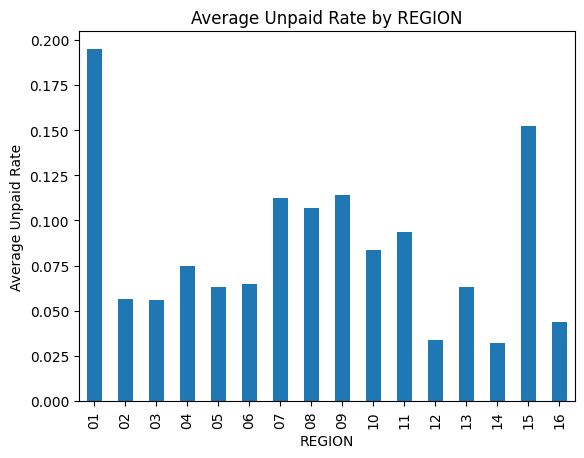

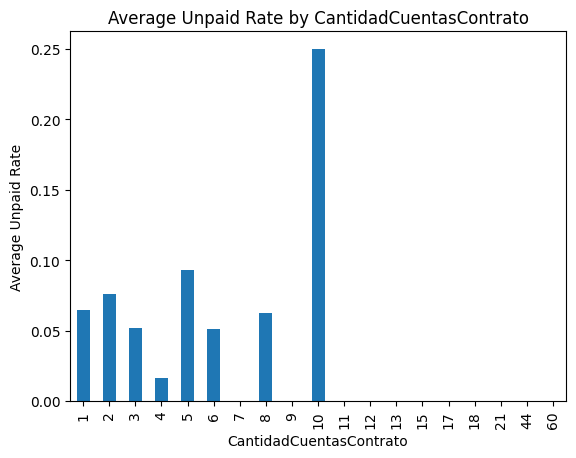

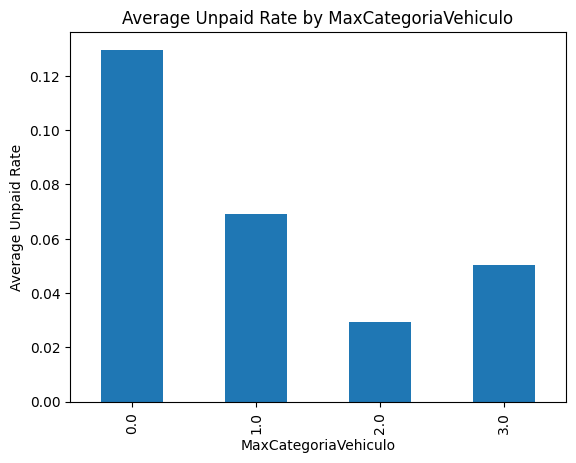

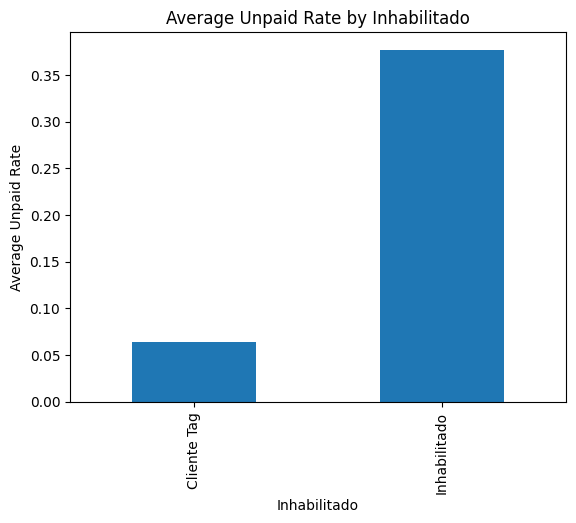

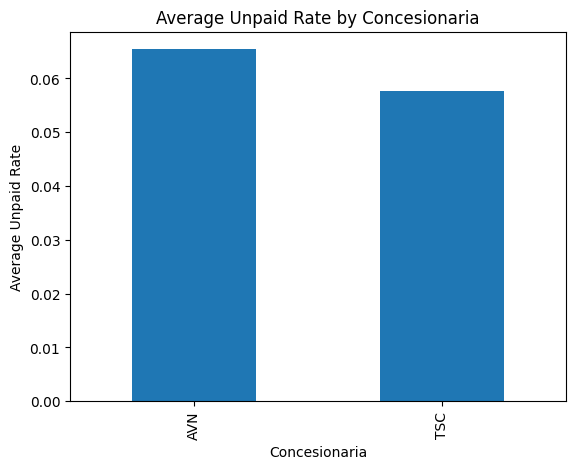

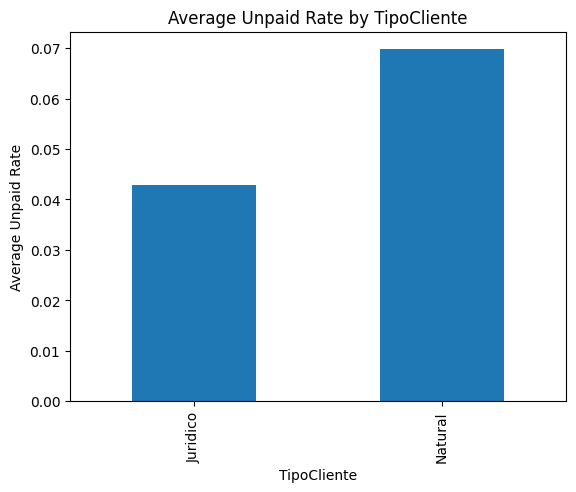

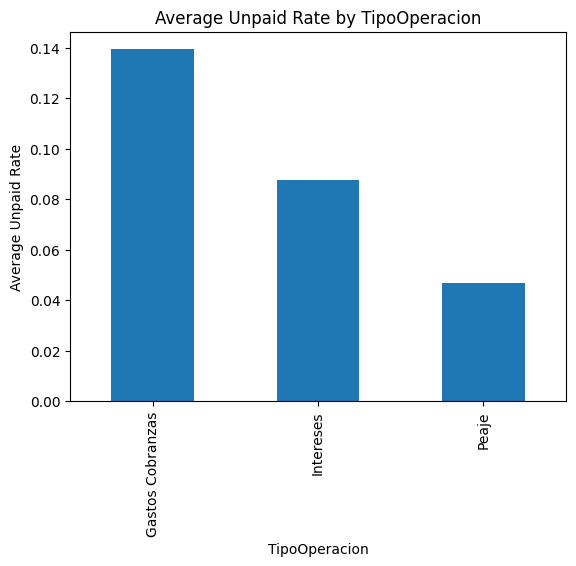

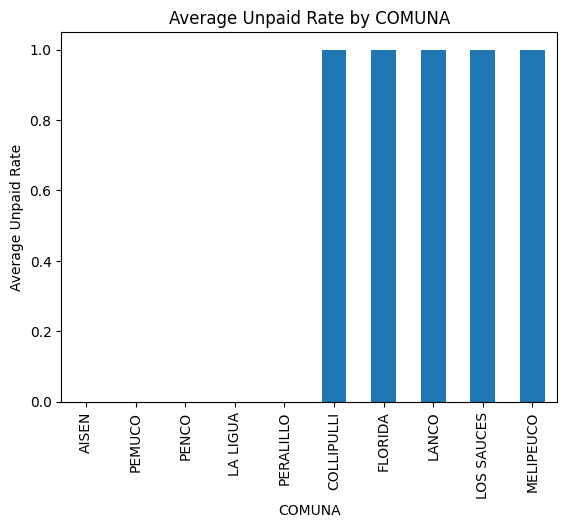

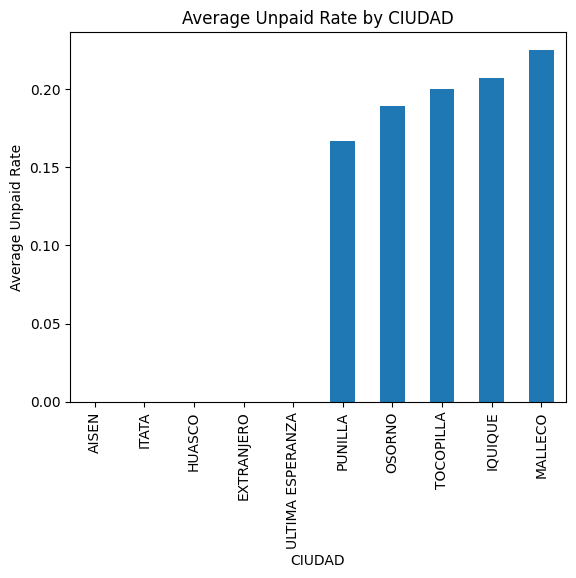

In [ ]:
import matplotlib.pyplot as plt
# List of variables to create separate graphs
variables = ["REGION", "CantidadCuentasContrato", "MaxCategoriaVehiculo",
             "Inhabilitado", "Concesionaria", "TipoCliente", "TipoOperacion", "COMUNA", "CIUDAD"]

# Plotting separate bar graphs for each variable
for variable in variables:

    if variable == "CIUDAD" or variable == "COMUNA" or variable == "CantidadVehiculos":
        # Group by the variable and calculate the average of 'Unpaid' for each group
        avg_unpaid_by_variable = df_selected_columns.groupby(variable)['Unpaid'].mean()

        avg_unpaid_by_variable = avg_unpaid_by_variable.sort_values()
        selected_values = pd.concat([avg_unpaid_by_variable.head(5), avg_unpaid_by_variable.tail(5)])
        #avg_unpaid_by_variable = selected_values['Unpaid'].mean()
        avg_unpaid_by_variable = selected_values

    else:
        # Group by the variable and calculate the average of 'Unpaid' for each group
        avg_unpaid_by_variable = df_selected_columns.groupby(variable)['Unpaid'].mean()

    # Plotting the bar graph
    avg_unpaid_by_variable.plot(kind='bar')
    plt.xlabel(variable)
    plt.ylabel('Average Unpaid Rate')
    plt.title(f'Average Unpaid Rate by {variable}')
    plt.show()

<ipython-input-16-cdf01e538be1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_columns.dropna(subset=continuous_variables + ['Unpaid'], inplace=True)


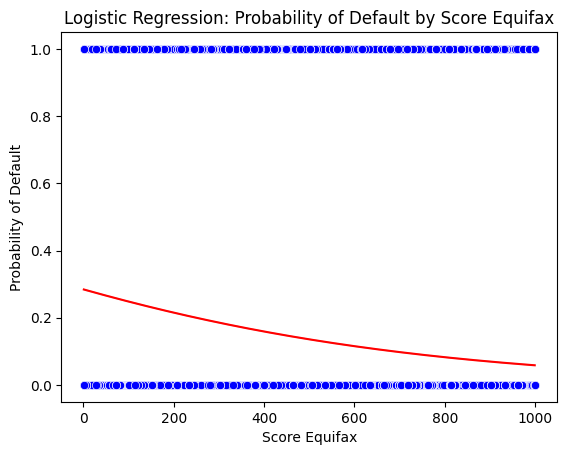

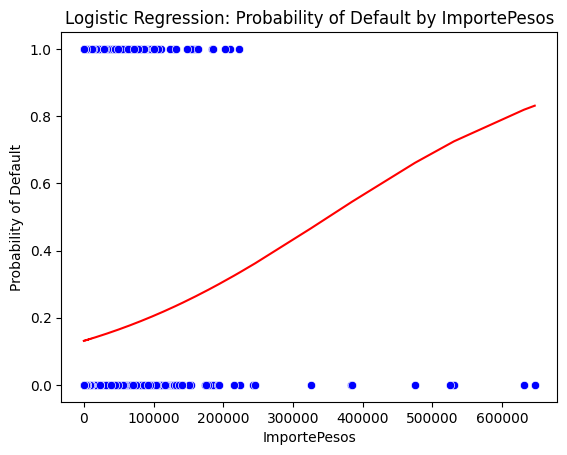

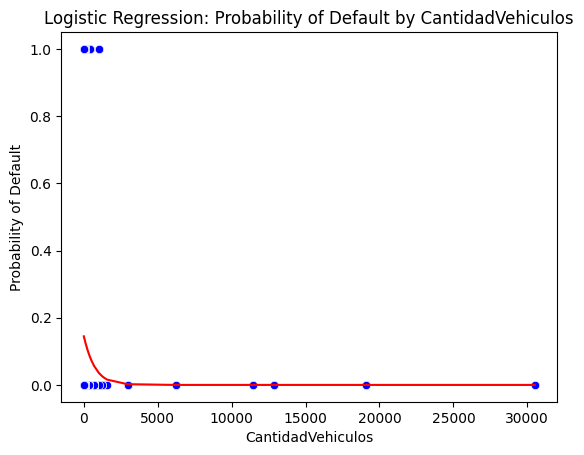

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
# List of variables to create scatter plots
variables = ["Score Equifax", "ImportePesos", "CantidadVehiculos"]
from sklearn.linear_model import LogisticRegression

# List of continuous variables
continuous_variables = ["Score Equifax", "ImportePesos", "CantidadVehiculos"]
# Drop rows with missing values
df_selected_columns.dropna(subset=continuous_variables + ['Unpaid'], inplace=True)

# Plotting logistic regression for each continuous variable
for variable in continuous_variables:
    # Fitting logistic regression model
    X = df_selected_columns[variable].values.reshape(-1, 1)
    y = df_selected_columns['Unpaid']
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    # Plotting the data points
    sns.scatterplot(x=variable, y='Unpaid', data=df_selected_columns, color='blue')

    # Plotting the logistic regression curve
    sns.lineplot(x=df_selected_columns[variable], y=model.predict_proba(X)[:,1], color='red')

    plt.xlabel(variable)
    plt.ylabel('Probability of Default')
    plt.title(f'Logistic Regression: Probability of Default by {variable}')
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# List of continuous variables
continuous_variables = ["CantidadVehiculos"]

# Drop rows with missing values
df_selected_columns.dropna(subset=continuous_variables + ['Unpaid'], inplace=True)

# Plotting logistic regression for each continuous variable
for variable in continuous_variables:
    # Fitting logistic regression model
    X = df_selected_columns[variable].values.reshape(-1, 1)
    y = df_selected_columns['Unpaid']
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    # Plotting the data points
    sns.scatterplot(x=variable, y='Unpaid', data=df_selected_columns, color='blue')

    # Plotting the logistic regression curve
    sns.lineplot(x=df_selected_columns[variable], y=model.predict_proba(X)[:,1], color='red')

    # Adjusting x-axis limits for CantidadVehiculos
    if variable == "CantidadVehiculos":
        plt.xlim(0, 300)  # Set the x-axis limit to 6000 vehicles

    plt.xlabel(variable)
    plt.ylabel('Probability of Default')
    plt.title(f'Logistic Regression: Probability of Default by {variable}')
    plt.show()


## Predictive model

In [ ]:
# Assuming df_selected_columns is your pandas DataFrame containing the selected columns
import pandas as pd

# Define the columns for which you want to create dummy variables
columns_to_dummify = [
    "COMUNA",
    "CIUDAD",
    "REGION",
    "CantidadCuentasContrato",
    "MaxCategoriaVehiculo",
    "CantidadVehiculos",
    "Inhabilitado",
    "Concesionaria",
    "TipoCliente",
    "TipoOperacion",
]

# Create dummy variables for each column and concatenate them with the original DataFrame
df_with_dummies = pd.get_dummies(df_selected_columns, columns=columns_to_dummify)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df_with_dummies.drop(columns=['Unpaid'])
y = df_with_dummies['Unpaid']

# Split the data into training and testing sets (90% training, 10% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Define class weights to balance the classes
class_weights = {0: 1, 1: 2}

# Initialize the logistic regression model with class weights
logreg = LogisticRegression(class_weight=class_weights)

# Train the logistic regression model on the training data
logreg.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = logreg.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of logistic regression model:", accuracy)


In [ ]:
(y_pred ==1).sum()

In [ ]:
(y_pred == 0).sum()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df_with_dummies.drop(columns=['Unpaid'])
y = df_with_dummies['Unpaid']

# Split the data into training and testing sets (90% training, 10% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Initialize the logistic regression model
logreg = LogisticRegression()

# Train the logistic regression model on the training data
logreg.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = logreg.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of logistic regression model:", accuracy)


In [ ]:
(y_pred ==1).sum()

In [ ]:
new_session.close()